# Assignment 1 - Creating and Manipulating Graphs

Eight employees at a small company were asked to choose 3 movies that they would most enjoy watching for the upcoming company movie night. These choices are stored in the file `assets/Employee_Movie_Choices.txt`.

A second file, `assets/Employee_Relationships.txt`, has data on the relationships between different coworkers. 

The relationship score has value of `-100` (Enemies) to `+100` (Best Friends). A value of zero means the two employees haven't interacted or are indifferent.

Both files are tab delimited.

In [5]:
import networkx as nx
import pandas as pd
import numpy as np


# This is the set of employees
employees = set(
    ["Pablo", "Lee", "Georgia", "Vincent", "Andy", "Frida", "Joan", "Claude"]
)

# This is the set of movies
movies = set(
    [
        "The Shawshank Redemption",
        "Forrest Gump",
        "The Matrix",
        "Anaconda",
        "The Social Network",
        "The Godfather",
        "Monty Python and the Holy Grail",
        "Snakes on a Plane",
        "Kung Fu Panda",
        "The Dark Knight",
        "Mean Girls",
    ]
)


# you can use the following function to plot graphs
# make sure to comment it out before submitting to the autograder
def plot_graph(G, weight_name=None):
    """
    G: a networkx G
    weight_name: name of the attribute for plotting edge weights (if G is weighted)
    """
    # %matplotlib notebook
    import matplotlib.pyplot as plt

    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = None

    if weight_name:
        weights = [int(G[u][v][weight_name]) for u, v in edges]
        labels = nx.get_edge_attributes(G, weight_name)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        nx.draw_networkx(G, pos, width=weights)
    else:
        nx.draw_networkx(
            G,
            pos,
        )

### Question 1

Using NetworkX, load in the bipartite graph from `assets/Employee_Movie_Choices.txt` and return that graph.

*This function should return a bipartite networkx graph with 19 nodes and 24 edges*

In [65]:
def answer_one():
    B = nx.Graph()

    data = pd.read_csv(r"assets/Employee_Movie_Choices.txt", delimiter="\t")
    employees = data["#Employee"].to_list()
    movies = data["Movie"].to_list()

    employees_nodes = set(employees)
    movies_nodes = set(movies)

    edges = [(employee, movie) for employee, movie in zip(employees, movies)]

    B.add_nodes_from(employees_nodes, bipartite=0)
    B.add_nodes_from(movies_nodes, bipartite=1)
    B.add_edges_from(edges)

    return B

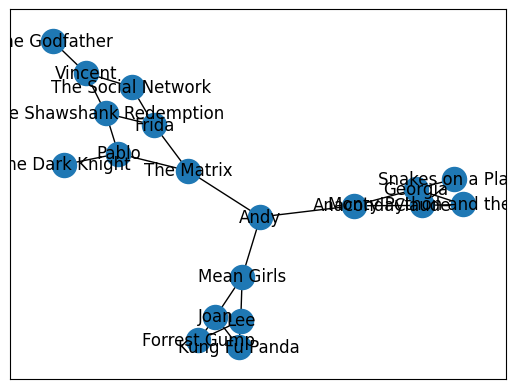

In [67]:
plot_graph(answer_one())

In [28]:
assert type(answer_one()) == nx.Graph, "Your return type should be a Graph object"

### Question 2

Using the graph from the previous question, add nodes attributes named `'type'` where movies have the value `'movie'` and employees have the value `'employee'` and return that graph.

*This function should return a bipartite networkx graph with node attributes `{'type': 'movie'}` or `{'type': 'employee'}`*

In [44]:
def answer_two():
    B = answer_one()
    for node, data in B.nodes(data=True):
        if data["bipartite"] == 0:
            B.nodes[node]["type"] = "employee"
        elif data["bipartite"] == 1:
            B.nodes[node]["type"] = "movie"

    return B

In [45]:
assert type(answer_two()) == nx.Graph, "Your return type should be a Graph object"

### Question 3

Find a weighted projection of the graph from `answer_two` which tells us how many movies different pairs of employees have in common.

*This function should return a weighted projected graph.*

In [60]:
def answer_three():
    B = answer_two()
    employee_nodes = [
        node for node, data in B.nodes(data=True) if data["bipartite"] == 0
    ]
    return nx.algorithms.bipartite.weighted_projected_graph(B, employee_nodes)

EdgeDataView([('Georgia', 'Andy', {'weight': 1}), ('Georgia', 'Claude', {'weight': 3}), ('Frida', 'Andy', {'weight': 1}), ('Frida', 'Pablo', {'weight': 2}), ('Frida', 'Vincent', {'weight': 2}), ('Vincent', 'Pablo', {'weight': 1}), ('Claude', 'Andy', {'weight': 1}), ('Joan', 'Andy', {'weight': 1}), ('Joan', 'Lee', {'weight': 3}), ('Pablo', 'Andy', {'weight': 1}), ('Andy', 'Lee', {'weight': 1})])

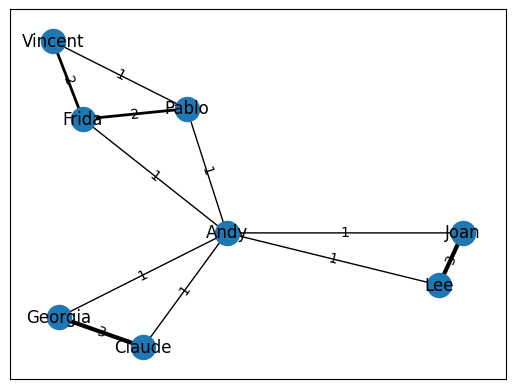

In [62]:
G = answer_three()
plot_graph(G, weight_name="weight")
G.edges(data=True)

In [53]:
assert type(answer_three()) == nx.Graph, "Your return type should be a Graph object"

### Question 4

Suppose you'd like to find out if people that have a high relationship score also like the same types of movies.

Find the pearson correlation between employee relationship scores and the number of movies they have in common. If two employees have no movies in common it should be treated as a 0, not a missing value, and should be included in the correlation calculation.

*This function should return a float.*

In [178]:
def answer_four():
    relationship_data = pd.read_csv(
        r"assets/Employee_Relationships.txt",
        delimiter="\t",
        header=None,
        names=["Employee1", "Employee2", "Relationship score"],
    )

    movie_edges = answer_three().edges(data=True)

    movie_data = {
        (name1, name2, weight["weight"]) for name1, name2, weight in movie_edges
    }

    movie_data = pd.DataFrame(movie_data, columns=["name1", "name2", "movies"])
    movie_data[["name1", "name2"]] = movie_data[["name2", "name1"]].where(
        movie_data["name1"] > movie_data["name2"], movie_data[["name1", "name2"]].values
    )

    relationship_data = pd.merge(
        relationship_data,
        movie_data,
        left_on=["Employee1", "Employee2"],
        right_on=["name1", "name2"],
        how="left",
    )
    relationship_data["movies"] = relationship_data["movies"].fillna(0)

    return float(
        relationship_data["Relationship score"].corr(relationship_data["movies"])
    )

In [179]:
ans_four = answer_four()
ans_four

0.7883962221733475